Iterative SLS example with nonlinear dynamics for the state [joint_pos, joint_vel, end_pos, end_vel] and the control [joint_acc] with a quadratic cost.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from copy import deepcopy
from time import time
import matplotlib.patches as mpatches
from time import sleep
import os


from isls import iSLS
from isls.utils import get_double_integrator_AB
from isls.projections import *
from isls.plot_utils import  plot_car

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from matplotlib import rc
from matplotlib.animation import FuncAnimation
rc('animation', html='html5')

### Problem parameters 

In [28]:
x_dim = 4
u_dim = 2 
T = 15.
N = 500
dt = T/N
print("dt:", dt)

dt: 0.03


#### Forward model f(x, u) and its jacobian get_AB(x, u)

In [29]:
# Dynamics functions
# x = [x_r, y_r, theta, v]
# u = [steering_angle, dv]
car_length=2. # Size of the car
l = car_length
def f(x, u):
    x1  = x[:, 0:1]  + dt * x[:, 3:4] * np.cos(x[:, 2:3])
    x2  = x[:, 1:2]  + dt * x[:, 3:4] * np.sin(x[:, 2:3])
    x3  = x[:, 2:3]  + dt * x[:, 3:4] * u[:, 0:1]
    x4  = x[:, 3:4]  + dt * u[:, 1:2]
    
    # Make theta stay inside [0, 2*pi]:
    x3 = x3%(2*np.pi)
    return np.concatenate([x1, x2, x3, x4],axis=-1)

def get_AB(x, u):
    A = np.tile(np.eye(d)[None], (N,1,1))
    B = np.zeros((N, d,u_dim))
    
    A[:, 0,2]  = dt * x[:, 3] * -np.sin(x[:, 2])
    A[:, 1,2]  = dt * x[:, 3] *  np.cos(x[:, 2])
    
    A[:, 0,3]  = dt * np.cos(x[:, 2])
    A[:, 1,3]  = dt * np.sin(x[:, 2])
    
    A[:, 2,3] = dt * u[:, 0]

    B[:, 2,0] = dt * x[:, 3]
    B[:, 3,1] = dt

    return A,B



#### Task definition

In [5]:
u_std=1e-2
x_std_r = 0
x_std = 1e2
# x_final_target =np.array([0.5, 0.5, -np.pi/2, 0])
x_final_target = np.zeros(d)
# viaQ_final = np.diag([50., 50., 50., 50.])
viaQ_final = np.diag([x_std]*d)

free_state = np.zeros(d)
# viaQ_free = np.diag([0]*d)
viaQ_free = np.diag([x_std_r]*2 + [0]*2)


zs = np.stack([free_state,  x_final_target])
Qs = np.stack([viaQ_free,  viaQ_final])

seq = np.zeros(N, dtype=np.int32)
seq[-1] = 1

In [6]:
## Initialize an iSLS object
sls = iSLS(x_dim=x_dim, u_dim=u_dim, N=N)

# Set the forward model
sls.forward_model = forward_model

# Set the cost function
sls.cost_function = cost

### Solve the unconstrained problem

In [10]:
# initial guess
u0 = np.random.normal(size=(N, u_dim))*0.
x0 = np.zeros(d)
x0 = np.array([1, 1, 3*np.pi/2, 0])
x_nom,u_nom = sls.rollout_batch(x0[None], u0[None])
x_nom = x_nom[0]
u_nom = u_nom[0]

In [11]:
sls.reset() # reset if you reinitialize the problem
sls.nominal_values = x_nom, u_nom
dp=1
print(sls.cost)

2420.6609902451055


In [12]:
%%time
# Solve
sls.solve_ilqr(get_AB, max_ilqr_iter=50, max_line_search_iter=40, dp=dp, verbose=False)
print(sls.cost_log)

Cost change is too low, cannot improve anymore at iteration 26 .
[2420.6609902451055, 2320.6621817679425, 917.6208462781556, 338.46805521158973, 230.24350606243257, 136.60720106493315, 88.57500415405518, 17.010470775242343, 10.50896639180609, 8.539742568155356, 6.638238777931788, 3.983034291168334, 2.732235640591311, 1.8711921134227345, 1.509824982028133, 1.296740788450828, 1.1049662172451036, 0.9483323642649973, 0.821725477628543, 0.7529933867870688, 0.7106446428496833, 0.6930428585263455, 0.6887587185444914, 0.6878831124605297, 0.6877024049778176, 0.6876652638936748, 0.6876575831166885]
Wall time: 1.43 s


[-4.36773e-05  8.68146e-05  3.76604e-04  1.24900e-03]


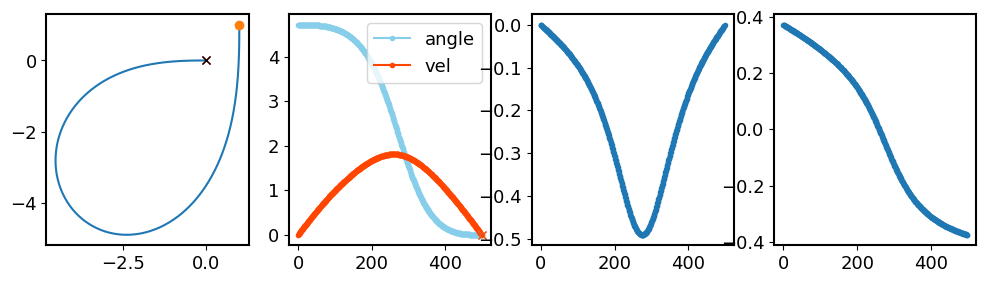

In [13]:
print(sls.x_nom[-1])
fig,ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot()
ax[0].plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax[0].plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax[0].plot(x_final_target[0], x_final_target[1], "rx")
ax[0].plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")

ax[1].plot(sls.x_nom[:,2], "skyblue",marker=".", label="angle")
ax[1].plot(sls.x_nom[:,3], "orangered", marker=".", label="vel")
ax[1].plot(N, x_final_target[2], "x", color="skyblue")
ax[1].plot(N, x_final_target[3], "x", color="orangered")


ax[1].legend()

ax[2].plot(sls.u_nom[:-1,0], ".")
ax[3].plot(sls.u_nom[:-1,1], ".")

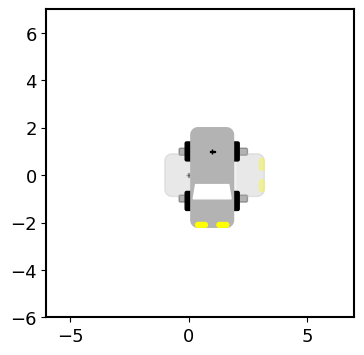

In [14]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False)
ax.set_aspect('equal')
# ax.grid()
ln, = ax.plot([], lw=2, color="k")
patches = plot_car(sls.x_nom[0], sls.u_nom[0])
patches_final = plot_car(x_final_target, np.zeros(u_dim))
for patch in patches_final:
    patch.set_alpha(0.3)
    ax.add_patch(patch)
    
def init():
    ax.set_xlim(-6, 7)
    ax.set_ylim(-6, 7)

    for patch in patches:
        ax.add_patch(patch)
    return patches

def update(i):
    [p.remove() for p in reversed(ax.patches[10:])]
    patches = plot_car(sls.x_nom[i], sls.u_nom[i])
    for patch in patches:
        ax.add_patch(patch)
    return patches

ani = FuncAnimation(fig, update, frames=np.arange(N)[::2], interval=20, init_func=init, blit=True)


## Solve the constrained problem

### Define constraints

In [15]:
### Control limits
lower_u1 = -.5
upper_u1 = .5

lower_u2 = -.5
upper_u2 = .5
def project_u(u):
    u_ = u.reshape(N,u_dim).copy()
    u_[:, 0] = project_bound(u_[:, 0], lower_u1, upper_u1)
    u_[:, 1] = project_bound(u_[:, 1], lower_u2, upper_u2)
    return u_.flatten()

In [18]:
u0 = np.random.normal(size=(N, u_dim))*0.
x_nom,u_nom = sls.rollout_batch(x0[None], u0[None])
x_nom = x_nom[0]
u_nom = u_nom[0]
sls.reset()
sls.nominal_values = x_nom, u_nom
sls.cost

2420.6609902451055

ADMM converged at iteration  4 !
ADMM residual is  0.00e+00 7.88e-02
Iteration number  0 iLQR cost:  2320.662738753802
ADMM can't improve anymore at iteration  1 !
ADMM residual is  0.00e+00 2.40e+01
ADMM residual change is  0.00e+00 3.01e-02
Iteration number  1 iLQR cost:  2079.0897944538224


C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ADMM residuals-> primal: 4.02e+00 dual: 6.99e+00
ADMM: Max iteration reached.
Iteration number  2 iLQR cost:  998.0983509512919
ADMM residuals-> primal: 2.33e+00 dual: 4.27e+00
ADMM: Max iteration reached.
Iteration number  3 iLQR cost:  585.8585958874129
ADMM residuals-> primal: 2.43e+00 dual: 2.00e+00
ADMM: Max iteration reached.
Iteration number  4 iLQR cost:  389.6090946627362
ADMM residuals-> primal: 4.05e+00 dual: 7.21e+00
ADMM: Max iteration reached.
Iteration number  5 iLQR cost:  207.9025517777668
ADMM residuals-> primal: 2.96e+00 dual: 6.19e+00
ADMM: Max iteration reached.
Iteration number  6 iLQR cost:  119.16776200759872
ADMM residuals-> primal: 2.25e+00 dual: 5.37e+00
ADMM: Max iteration reached.
Iteration number  7 iLQR cost:  79.54384963719357
ADMM residuals-> primal: 1.77e+00 dual: 4.41e+00
ADMM: Max iteration reached.
Iteration number  8 iLQR cost:  54.540534244380794
ADMM residuals-> primal: 1.36e+00 dual: 3.64e+00
ADMM: Max iteration reached.
Iteration number  9 iLQR

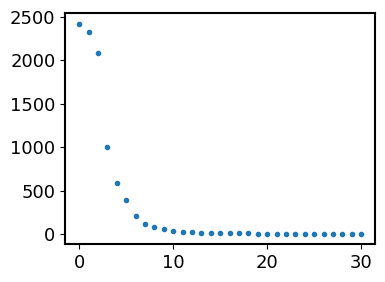

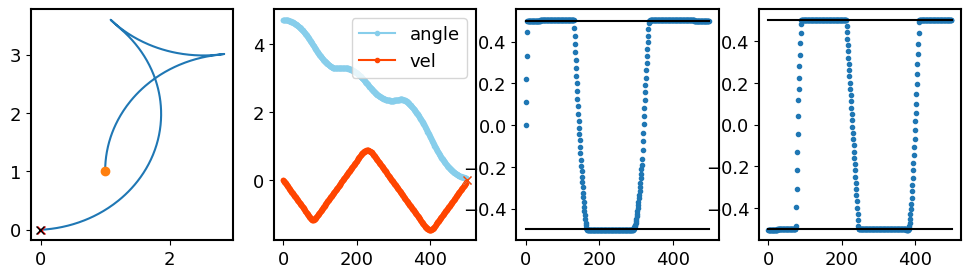

In [19]:
%%time
Rr = 1e1
alpha = 1. # relaxation parameter for ADMM
k_max = 30
log = sls.ilqr_admm(get_AB, project_u=project_u, max_admm_iter=5,
                        max_line_search=50, rho_x=None, rho_u=Rr, alpha=alpha, k_max=k_max, 
                    threshold=1e-1, verbose=1, log=True)
plt.plot(sls.cost_log,".")
# plt.plot(log, ".")
print(sls.x_nom[-1])
fig,ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot()
ax[0].plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax[0].plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax[0].plot(x_final_target[0], x_final_target[1], "rx")
ax[0].plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")

ax[1].plot(sls.x_nom[:,2], "skyblue",marker=".", label="angle")
ax[1].plot(sls.x_nom[:,3], "orangered", marker=".", label="vel")
ax[1].plot(N, x_final_target[2], "x", color="skyblue")
ax[1].plot(N, x_final_target[3], "x", color="orangered")


ax[1].legend()

ax[2].plot(sls.u_nom[:-1,0], ".")
ax[3].plot(sls.u_nom[:-1,1], ".")

lower_us = [lower_u1, lower_u2]
upper_us = [upper_u1, upper_u2]

for i in range(2):
    ax[2+i].plot([0,N],[lower_us[i]]*2, "k")
    ax[i+2].plot([0,N],[upper_us[i]]*2, "k")

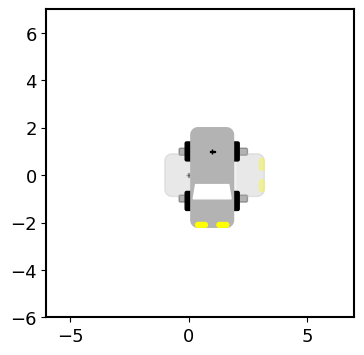

In [20]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False)
ax.set_aspect('equal')
# ax.grid()
ln, = ax.plot([], lw=2, color="k")
patches = plot_car(sls.x_nom[0], sls.u_nom[0])
patches_final = plot_car(x_final_target, np.zeros(u_dim))
for patch in patches_final:
    patch.set_alpha(0.3)
    ax.add_patch(patch)
    
def init():
    ax.set_xlim(-6, 7)
    ax.set_ylim(-6, 7)

    for patch in patches:
        ax.add_patch(patch)
    return patches

def update(i):
    [p.remove() for p in reversed(ax.patches[10:])]
    patches = plot_car(sls.x_nom[i], sls.u_nom[i])
    for patch in patches:
        ax.add_patch(patch)
    return patches

ani = FuncAnimation(fig, update, frames=np.arange(N)[::2], interval=20, init_func=init, blit=True)
# HTML(ani.to_html5_video())
